In [21]:
# Synapse Classification Challenge
# Introduction to Connectomics 2017
# D. Qian (your name here)

your_name = 'qian_daniel'

!pip install mahotas
!pip install ndparse
%matplotlib inline

In [22]:
# Load data

import numpy as np

data = np.load('./synchallenge2017_training.npz')

imtrain = data['imtrain']
annotrain = data['annotrain']
ytrain = data['ytrain']

data = np.load('./synchallenge2017_validation.npz')

imvalid = data['imvalid']
annovalid = data['annovalid']
yvalid = data['yvalid']

In [23]:
# Stuff for one feature that didn't work

from copy import copy
import ndparse as ndp
import math

def getRegions(im):
    regions = []
    for i in range(0, 180, 5):
        # Unit circle with radius 6
        x = 3.0 * math.cos(i * math.pi / 180.0)
        y = 3.0 * math.sin(i * math.pi / 180.0)

        avgs = [0, 0, 0]
        counts = [0, 0, 0]
        
        # Special case with vertical lines
        if (y == 0):
            for row in range(-32, 32):      
                for col in range(-32, 32):
                    intensity = im[row+32][col+32]
                    if (col < -x):
                        avgs[0] += intensity
                        counts[0] += 1;
                    elif (col < x):
                        avgs[1] += intensity
                        counts[1] += 1;
                    else:
                        avgs[2] += intensity
                        counts[2] += 1;    
                        
        # Look at eqn for two opposing tangent lines
        # figure out whether point is above, in between or below
        else:
            slope = -x/y
            for col in range(-32, 32):    
                expy1 = slope * (col - x) + y
                expy2 = slope * (col + x) - y

                for row in range(-32, 32):
                    intensity = im[row+32][col+32]

                    if (row < expy2):
                        avgs[0] += intensity
                        counts[0] += 1;
                    elif (row < expy1):
                        avgs[1] += intensity
                        counts[1] += 1;
                    else:
                        avgs[2] += intensity
                        counts[2] += 1; 
              
        for j in range(0, 3):
            avgs[j] /= counts[j]
        regions.append(avgs)
    return regions
        
def findBorderInfo(im):
    regions = getRegions(im)
    minInt = 256
    minVals = []
    i = 0;
    for region in regions:
        if (region[1] < minInt):
            minInt = region[1]
            minVals = region
        i += 5
    return minVals

In [24]:
# Define feature extraction code

import skimage.feature as skif
import skimage.measure as skim
    
def extract_features(imdata):
    xtrain = []
    
    progress = 0;
    for im in imdata:
        fvector = []
        
#       STEPS THAT DIDN'T WORK
#       ------------------------------------------------------
#       Normalize each image, so differences in exposure and contrast
#       matter less. Actually made it worse
#       im *= int(255.0/float(im.max()))
       
#       Try and find a section centered on the middle (accounting for rotation)
#       that is dark/synapsey
#       Also super computationally expensive
#       Gives a f1 score of .77 on its own
#       for val in findBorderInfo(im):
#           fvector.append(val)
    
#       Also brought score down
#       for feature in np.ravel(skif.hessian_matrix(im)):
#           fvector.append(feature)

        # add a contrast feature
        g = skif.greycomatrix(im, [1, 2], [0, np.pi/2],normed=True, symmetric=True)
        homogeneity = skif.greycoprops(g, 'homogeneity')
        
        # explict way to add feature elements one at a time
        homogeneity = np.ravel(homogeneity)
        for i in homogeneity:
            fvector.append(i)
            
        # Add each pixel of the (approx.) the center third of the image,
        # since these are features
        low = 20 
        high = 45 
        for row in range(low, high):      
            for col in range(low, high):
                fvector.append(im[row][col])
        
        fvector = np.asarray(fvector)
        xtrain.append(fvector)

    return np.asarray(xtrain)
    

In [25]:
# Extract Features from training

xtrain = extract_features(imtrain)
# Train Classifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(xtrain, ytrain)

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(xtrain.shape[1]):
    pass
#     print("%d. Feature %d: (%f)" % (f + 1 % 4, indices[f], importances[indices[f]]))



In [26]:
# Extract features from validation set
xvalid = extract_features(imvalid)


In [27]:
# Run Classifier on validation set
scoresvalid = clf.predict_proba(xvalid)

In [28]:
# Best f1 score report on validation set

from sklearn.metrics import f1_score

# Can add post-processing here if desired

prob_syn = scoresvalid[:,1]

# default threshold
print('default f1 score: {}'.format(np.round(f1_score(yvalid, prob_syn >=0.5),6)))

f1_out = 0
thresh = 0
for i in np.arange(0.0, 1, 0.05):
    f1_test =  f1_score(yvalid, prob_syn > i)
    if f1_test > f1_out:
        f1_out = f1_test
        thresh = i

print('My best validation f1-score is: {} at {} threshold.'.format(np.round(f1_out,6), thresh))

default f1 score: 0.901449
My best validation f1-score is: 0.902321 at 0.5 threshold.


synapse present - true positive


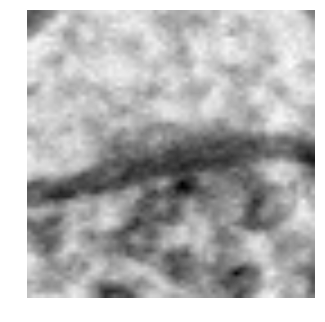

no synapse present - true negative


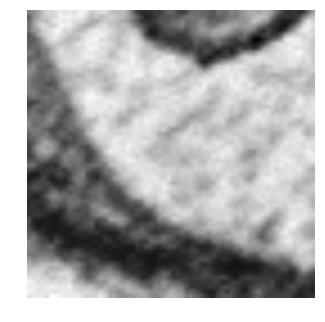

synapse present - false negative


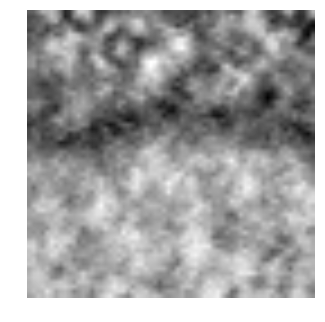

no synapse present - false positive


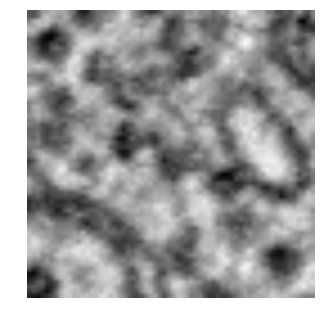

In [29]:
# here we can inspect results

valid_labels = np.asarray(prob_syn > thresh,dtype='int')
# find images we did well on
idx_correct_syn = np.where((valid_labels == yvalid) & (yvalid == 1))[0]
idx_correct_nosyn = np.where((valid_labels == yvalid) & (yvalid == 0))[0]
# find images we did poorly on

idx_wrong_syn = np.where((valid_labels != yvalid) & (yvalid == 1))[0]
idx_wrong_nosyn = np.where((valid_labels != yvalid) & (yvalid == 0))[0]

print('synapse present - true positive')
ndp.plot(imvalid[idx_correct_syn[3]])

print('no synapse present - true negative')
ndp.plot(imvalid[idx_correct_nosyn[3]])

print('synapse present - false negative')
ndp.plot(imvalid[idx_wrong_syn[3]])

print('no synapse present - false positive')
ndp.plot(imvalid[idx_wrong_nosyn[3]])

In [30]:
# Validate performance on test set (should only run/score once!)

data = np.load('./synchallenge2017_test_notruth.npz')

imtest = data['imtest']
annotest = data['annotest']

# Extract features from test set
xtest = extract_features(imtest)

# Run classifier on test set
scoretest = clf.predict_proba(xvalid)

# Post-processing
prob_syntest = scoretest[:,1]
syntest_predict = prob_syntest > thresh
syntest_predict = np.asarray(syntest_predict,dtype = 'uint8')

# save file and upload to google docs with label vector
np.save(your_name+'_synchallenge_testdata.npy',syntest_predict)